In [1]:
import numpy as np
import math
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [12]:
x_tt = 50
y_tt = -30
c = 1e-3*math.pi/180/3600
print y_tt*c*5344e3
D = 25.5
nPx = 101

zen = 0e3*c
azm = math.pi/2
csrc   = ceo.Source("R",zenith=zen,azimuth=azm,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])
M1 = ceo.GMT_M1(D,nPx)
M2 = ceo.GMT_M2(D,nPx)

-0.777253293555


In [13]:
#M1.reset()
#M1.global_tiptilt(5*math.pi/180,0.*math.pi/180.0/3600)

In [14]:
def src_pick_up():
    ox = np.tan(zen)*np.cos(azm)
    oy = np.tan(zen)*np.sin(azm)
    u = linspace(-1,1,nPx)
    xx,yy = meshgrid(u,u)
    P = csrc.rays.vignetting.host()
    wfs_offset = P.reshape(nPx,nPx)*(ox*xx + oy*yy)*D/2
    return wfs_offset

In [15]:
def optical_system(src,x,radius):
    src.stop(M2)
    src.trace(M1)
    src.trace(M2)
    src.rays.go_sphere(x,radius)
    src.opd2phase()
    cu_wfs_offset = ceo.cuFloatArray(host_data=src_pick_up())
    src.phase = cu_wfs_offset


In [16]:
def opd_res_fun(x,radius):
    csrc.reset()
    optical_system(csrc,x,radius)
    opd_res = np.reshape( csrc.phase.host(), (-1,1) )*1e9
    P = csrc.rays.vignetting.host()
    return np.std(opd_res[P.ravel(0)>0])

In [17]:
from scipy.optimize import minimize_scalar
#print opd_fun(5.83001949259)
sphere_radius = 50
#res = minimize_scalar(opd_fun, bounds=(26.09249-b,26.09249+b), method='bounded')
res = minimize_scalar(opd_res_fun, bounds=(25,30), method='bounded',args=(sphere_radius,))
print res.success
print res.x
chief_xyz = csrc.rays.chief_coordinates.host() - sphere_radius*csrc.rays.chief_directions.host()
print "Minimum wfe rms focus @ [%6.4f,%6.4f,%6.4f]m with rms wfe=%6.4fnm"%(chief_xyz[0,0],chief_xyz[0,1],chief_xyz[0,2],opd_res_fun(res.x,sphere_radius))

True
26.0924944433
Minimum wfe rms focus @ [0.0000,-0.0000,-5.8300]m with rms wfe=1.3642nm


In [18]:
nzen = zen# + 0.11579*x_tt*c
gs    = ceo.Source("R",zenith=nzen,azimuth=azm,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])

<matplotlib.colorbar.Colorbar instance at 0x2b00a3b2b908>

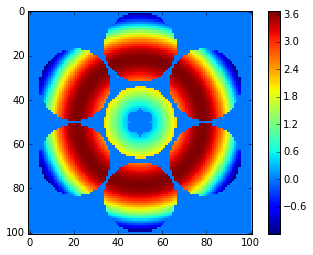

In [19]:
gs.reset()
M1.reset()
M2.reset()
optical_system(gs,res.x,sphere_radius)
opd0 = gs.phase.host(units='nm')
figure
imshow(opd0,interpolation='none')
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b00a3c9ba70>

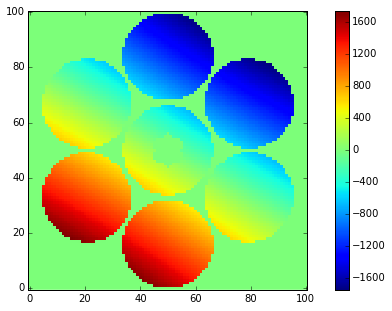

In [20]:
gs.reset()
M1.reset()
M2.reset()
M2.tiptilt_neutral(x_tt*c,y_tt*c)
optical_system(gs,res.x,sphere_radius)
opd_glb = gs.phase.host(units='nm')
fig, ax2 = subplots(ncols=1)
fig.set_size_inches(10,5)
h2 = ax2.imshow(opd_glb,interpolation='none',origin='lower')
colorbar(h2)

In [25]:
M2.motion_CS.origin

array([[ -7.98018138e-07,  -1.21952335e-06,  -5.92678541e-07],
       [  7.52830793e-07,  -1.24344464e-06,  -6.04304088e-07],
       [  1.55084895e-06,  -2.39212292e-08,  -1.16257596e-08],
       [  7.98018138e-07,   1.21952353e-06,   5.92678132e-07],
       [ -7.52830868e-07,   1.24344481e-06,   6.04303680e-07],
       [ -1.55084899e-06,   2.39213405e-08,   1.16253352e-08],
       [  7.77253296e-07,   1.29542208e-06,  -2.13162821e-13]])

In [54]:
M2.motion_CS.euler_angles

array([[ -4.84813654e-07,   5.74275776e-23,   1.50722559e-23],
       [ -2.42406805e-07,  -4.06106802e-07,  -1.06585528e-07],
       [  2.42406849e-07,  -4.06106776e-07,  -1.06585627e-07],
       [  4.84813654e-07,  -0.00000000e+00,   0.00000000e+00],
       [  2.42406849e-07,   4.06106776e-07,   1.06585627e-07],
       [ -2.42406805e-07,   4.06106802e-07,   1.06585528e-07],
       [  4.84813654e-07,  -0.00000000e+00,   0.00000000e+00]])

In [59]:
z = zen*exp(1j*azm)# + 0.11579*(x_tt+1j*y_tt)*c*exp(1j*math.pi/2)
gs    = ceo.Source("R",zenith=0*np.abs(z),azimuth=0*np.angle(z),
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,-25])

<matplotlib.colorbar.Colorbar instance at 0x2b169094ea70>

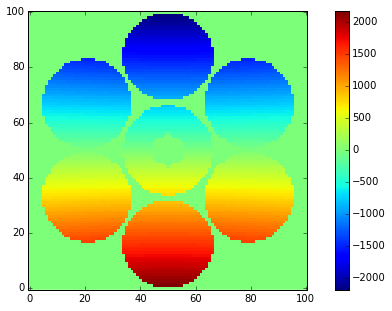

In [60]:
gs.reset()
M1.reset()
M2.reset()
M2.coma_neutral(x_tt*c,y_tt*c)
optical_system(gs,res.x,sphere_radius)
opd_glb = gs.phase.host(units='nm')
fig, ax2 = subplots(ncols=1)
fig.set_size_inches(10,5)
h2 = ax2.imshow(opd_glb,interpolation='none',origin='lower')
colorbar(h2)

In [61]:
M2.motion_CS.origin

array([[ -1.41827261e-22,  -9.86296191e-07,  -8.04072348e-07],
       [  1.00295055e-06,  -4.93148091e-07,  -4.02036318e-07],
       [  1.00295066e-06,   4.93148295e-07,   4.02035791e-07],
       [  0.00000000e+00,   9.86296581e-07,   8.04071870e-07],
       [ -1.00295066e-06,   4.93148295e-07,   4.02035791e-07],
       [ -1.00295055e-06,  -4.93148091e-07,  -4.02036318e-07],
       [  0.00000000e+00,   1.08889147e-06,  -2.64233080e-13]])

In [62]:
M2.motion_CS.euler_angles

array([[ -4.84813654e-07,   5.74275776e-23,   1.50722559e-23],
       [ -2.42406805e-07,  -4.06106802e-07,  -1.06585528e-07],
       [  2.42406849e-07,  -4.06106776e-07,  -1.06585627e-07],
       [  4.84813654e-07,  -0.00000000e+00,   0.00000000e+00],
       [  2.42406849e-07,   4.06106776e-07,   1.06585627e-07],
       [ -2.42406805e-07,   4.06106802e-07,   1.06585528e-07],
       [  4.84813654e-07,  -0.00000000e+00,   0.00000000e+00]])